# 07 - Parameter Recovery: Time-resolved Method

In this tutorial, we will continue our discussion of optical property fitting, but using time-resolved data. The nice thing about time-resolved measurement is that we can leverage the shape information of *a* TPSF, and therefore use only one source and one detector. The idea is very similar to what we used in the last tutorial: find the combination of $\mu_a$ and $\mu_s'$, such that the analytical TPSF and the measured TPSF have the same shape. We can also use the TPSF slightly differently by using its moments: if we compare the analytical version of the first and second moments with the measured, we have a second way of fitting optical parameters. We will discuss a third way of using TR data by combining moments and multi-distance methods later, but let's first start with flavor number one.

We start with constructing the same slab model.

In [1]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# create a uniform volume, make sure it's in uint8
vol = np.ones((60,60,50), dtype=np.uint8)
# create a mesh from it
# meshing parameter; small cell size for accurate tpsf calculation
params = ff.utils.MeshingParams(general_cell_size=1, lloyd_smooth=0)
# optodes
sources = ff.base.optode(np.array([10,30,0]))
detectors = ff.base.optode(np.array([[20,30,0], 
                                    [30,30,0],
                                    [40,30,0],
                                    [50,30,0]]))
link = np.array([[1,1],
                [1,2],
                [1,3],
                [1,4]], dtype=np.int32) # if the third column is missing, automatically assumed to be all 1
# optical properties
prop = np.array([[1, 0.015, 0.9, 1.33]])
# now mesh
mesh = ff.base.stndmesh()
mesh.from_volume(vol, params, prop=prop, src=sources, det=detectors, link=link)

Running CGAL mesher
Meshing...

Running local optimization...

Converting to NIRFAST format


We only need one source-detector pair for now, but let's keep the same array, as they will become relevant later.

Calculate the TPSF and have a look.

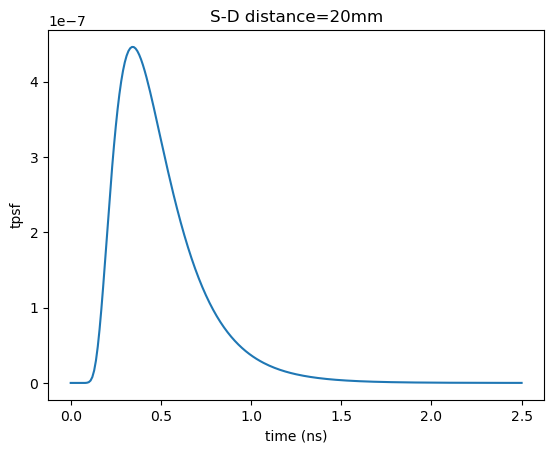

In [19]:
data = mesh.femdata_tpsf(2.5e-9, 1e-11)[0]

plt.plot(data.time*1e9, data.tpsf[1,:])
plt.xlabel('time (ns)')
plt.ylabel('tpsf')
plt.title('S-D distance=20mm')
plt.show()

Now let's do the fitting

In [22]:
from scipy import optimize
def myfunc(tvec, mua, musp):
    phi = ff.forward.semi_infinite_TR(mua, musp, 1.3, 20, tvec, 0, boundary='ebc-exact') # last argument is dt, which has no effect here
    return phi[:,1] / phi.max() # normalize amplitude to 1

ydata = data.tpsf[1,1:].squeeze() / data.tpsf[1,:].max()
# we need to specify the bounds of the search
# let's say mua must be between 0.001~0.1 mm-1, and musp 0.1~10 mm-1
fitted = optimize.curve_fit(myfunc, data.time[1:], ydata, bounds=([1e-3, 1e-1], [1e-1, 1e1]))[0]
print(fitted)

[0.01530496 0.9399759 ]


We can plot the analytical results using the fitted parameters together with the FEM results, and see how good our fit is.

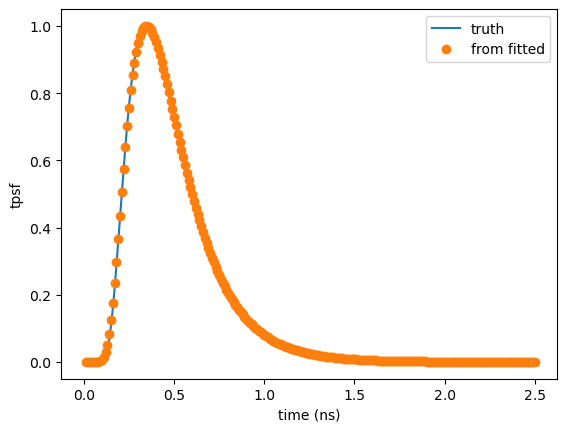

In [24]:
plt.plot(data.time*1e9, data.tpsf[1,:]/data.tpsf[1,:].max())
plt.plot(data.time[1:]*1e9, myfunc(data.time[1:], fitted[0], fitted[1]), 'o')
plt.xlabel('time (ns)')
plt.ylabel('tpsf')
plt.legend(['truth', 'from fitted'])

plt.show()

Now let's have a look at flavor number two: using moments, or specifically, the mean time of flight and the variance of the time of flight. If we use the solution in semi-infinite media, denote the source-detector distance by $\rho$, according to [this paper](https://doi.org/10.1364/AO.42.005785), the optical properties are given by,
$$
\mu_a=\frac{m_1^3}{2\nu V(m_1^2+V)}
$$
$$
\mu_s'=\frac{2m_1\nu(m_1^2+V)}{3\rho^2V}
$$
where $\nu$ is the light speed in the medium, $m_1=\langle t\rangle$, $V=\langle t^2\rangle-\langle t\rangle^2$, and if we denote the TPSF by $g(t)$, $\langle t^k\rangle=\frac{\int_{-\infty}^\infty t^kg(t)dt}{\int_{-\infty}^\infty g(t)dt}$.

Let's give it a try.

In [27]:
m0 = data.tpsf[1,:].sum()
m1 = np.sum(data.time * data.tpsf[1,:]) / m0
m2 = np.sum(data.time**2 * data.tpsf[1,:]) / m0
V = m2 - m1**2

v = 3e11/1.33
rho = 20.
mua_hat = m1**3 / (2*v*V*(m1**2 + V))
musp_hat = 2*m1*v*(m1**2 + V) / (3 * rho**2 * V)
print(mua_hat)
print(musp_hat)

0.015490426196282889
0.9703841751207187


We can finally have a look at the third flavor. Under further approximation when $\rho\gg1/\sqrt{3\mu_a\mu_s'}$, the semi-infinite medium solution actually merges into the infinite medium, in which case, very nicely, both $m_1$ and $V$ scale linearly with $rho$. Therefore, if we measure these two quantities at multiple distances, we can use the slope for calculating $\mu_a$ and $\mu_s'$.

Let's first plot them, and make sure the linear approximation is a reasonable one.

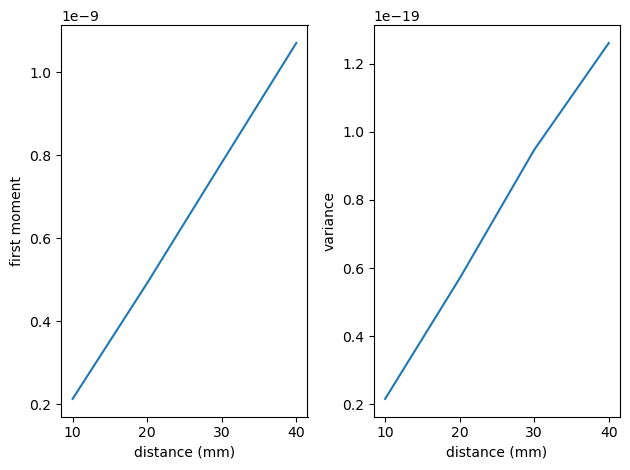

In [28]:
m0 = data.tpsf.sum(axis=1)
m1 = np.sum(data.time * data.tpsf, axis=1) / m0
m2 = np.sum(data.time**2 * data.tpsf, axis=1) / m0
V = m2 - m1**2

rho = np.array([10., 20., 30, 40])
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(rho, m1)
ax1.set_xlabel('distance (mm)')
ax1.set_ylabel('first moment')

ax2.plot(rho, V)
ax2.set_xlabel('distance (mm)')
ax2.set_ylabel('variance')

plt.tight_layout()
plt.show()

That's fairly linear. If we denote the two slopes by $S_1$ and $S_2$, rearranging the expressions from [this paper](https://doi.org/10.1364/AO.42.005785) gives us
$$
\mu_a=\frac{S_1}{2\nu S_2}
$$
$$
\mu_s'=\frac{2\nu S_1^3}{3 S_2}-\mu_a
$$

Let's have a try.

In [29]:
s1 = np.linalg.pinv(np.c_[np.ones(4), rho]) @ m1
s1 = s1[1]
s2 = np.linalg.pinv(np.c_[np.ones(4), rho]) @ V
s2 = s2[1]

mua_hat = s1/(2*v*s2)
musp_hat = (2*v*s1**3)/(3*s2) - mua_hat

print(mua_hat)
print(musp_hat)

0.018053534201384135
0.98501505866684


This is not perfect, but not too far off.

You may have noticed that the variances are quite small, and it's not hard to imagine that in real-life data where noise is present, the estimation of it can be inaccurate. If you do wish to use the moments (flavor \#2 and \#3 discussed here) for parameter recovery, you need to be very cautious.

Of course, instead of the first and the second moments, you can elect to use the *zeroth* (that is, the intensity) and first moments in order to avoid the concerns about noisy variance estimation. The curious reader is encouraged to derive the expressions for themselves.

This concludes the two-part tutorial on baseline optical property fitting.